In [785]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, precision_score, matthews_corrcoef, recall_score,f1_score, log_loss
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot as plt
import warnings

# Data Import + EDA + Feature Engineering

In [786]:
df = pd.read_csv('census_data.csv')

In [787]:
df.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


Based on the first eye test, we see that education_num and education seem to correlate perfectly. So let's drop education_num as it arbitrarily ordinally scales the data numerically. Instead, we will use leave one out target encoding on the education column.

In [788]:
df = df.drop('education_num', axis=1)

In [789]:
round(df.describe(),2)

,age,fnlwgt,capital_gain,capital_loss,hours_per_week
count,48842.00,48842.00,48842.00,48842.0,48842.00
mean,38.64,189664.13,1079.07,87.5,40.42
std,13.71,105604.03,7452.02,403.0,12.39
min,17.00,12285.00,0.00,0.0,1.00
25%,28.00,117550.50,0.00,0.0,40.00
50%,37.00,178144.50,0.00,0.0,40.00
75%,48.00,237642.00,0.00,0.0,45.00
max,90.00,1490400.00,99999.00,4356.0,99.00


Let's perform a basic check for NaN values, which we would have to either drop or impute, if existing.

In [790]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

When checking the target feature, income, we see that for each value we actually have two values, one with a period and one without. So let's remove it, so that we have two unique values.

In [791]:
df['income'].value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: income, dtype: int64

In [792]:
df['income'] = df['income'].str.strip('.')

While we are at, let us also look at the distribution of our target feature, which is roughly 75/25 split. This can serve as a first baseline for a model, meaning our model must perform better than 76.1% accuracy to be viable.

In [793]:
round(df['income'].value_counts(normalize=True)*100,1)

 <=50K    76.1
 >50K     23.9
Name: income, dtype: float64

Let's also convert our target feature from a string into a binary 0/1 integer representation.

In [794]:
df['income'] = df['income'].str.replace('>50K', '1')
df['income'] = df['income'].str.replace('<=50K', '0')
df['income'] = df['income'].astype(int)

In [795]:
df['income'].value_counts()

0    37155
1    11687
Name: income, dtype: int64

In order to reduce dimensionality, let's bring together capital gain and loss, by substracting the losses from the gain to create net profit.

In [796]:
df['net_capital_profit'] = df['capital_gain'] - df['capital_loss']
df = df.drop(['capital_loss', 'capital_gain'], axis=1)

Next, let's plot some of our continuous features to look at their distribution and potential outliers

<AxesSubplot:>

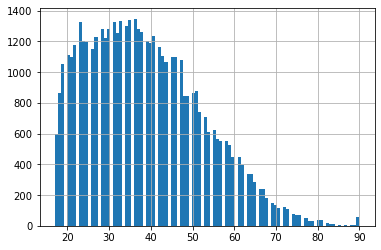

In [797]:
df['age'].hist(bins=100)

<AxesSubplot:>

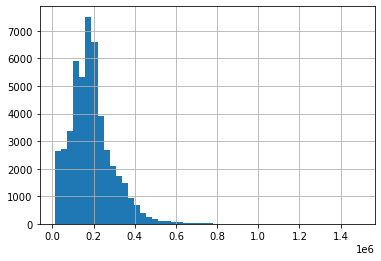

In [798]:
df['fnlwgt'].hist(bins=50)

Our new net profit feature looks quite sparse, so let's convert it into a categorical feature to reduce some noise, by denoting all negative cases with -1, all cases with 0 profit with 0 and all cases with actual profit with 1.

<AxesSubplot:>

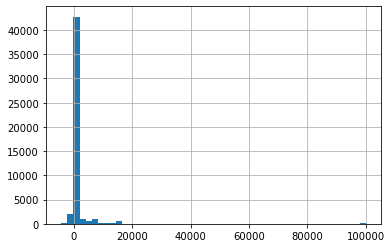

In [799]:
df['net_capital_profit'].hist(bins=50)

In [800]:
df.loc[df['net_capital_profit'] < 0, 'net_capital_profit'] = -1
df.loc[df['net_capital_profit'] == 0, 'net_capital_profit'] = 0
df.loc[df['net_capital_profit'] > 0, 'net_capital_profit'] = 1

Next, we we split the data into train/test sets after shuffling it. We stratify by income to ensure an equal distribution in both training and test set. Use stratification only if you have a decent understanding of your data.

# Train/Test Split + Feature Encoding/Scaling

In [801]:
df = df.sample(frac=1) # shuffle data
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.33, stratify=df['income'],random_state=42)

In order to encode categorical features and  scale numerical ones, we need to define them in a list.

In [802]:
cat_cols = ['native_country', 'sex', 'race', 
            'relationship', 'occupation', 'marital_status', 
            'education', 'workclass', 'net_capital_profit']

num_cols = ['age', 'fnlwgt', 'hours_per_week']

to encode categorical features we use a leave one out encoder.

Leave-one-out encoding (LOO or LOOE) is an example of target-based encoding—it prevents target data leakage, unlike other target-based methods. As its name suggests, the method consists of calculating the mean target of a given category k for observation j without using the corresponding target of j.

Source: https://heartbeat.fritz.ai/hands-on-with-feature-engineering-advanced-methods-in-python-for-machine-learning-e05bf12da06a

We fit the encoder on our training data only and apply the transformation of the test data based on this, so no 'cheating' occurs.

In [803]:
loo = ce.LeaveOneOutEncoder(cols=cat_cols, drop_invariant=True)
loo.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


LeaveOneOutEncoder(cols=['native_country', 'sex', 'race', 'relationship',
                         'occupation', 'marital_status', 'education',
                         'workclass', 'net_capital_profit'],
                   drop_invariant=True)

In [804]:
X_train = loo.transform(X_train)
X_test = loo.transform(X_test)

We also scale our numerical data between 0 and 1, because some algorithms have difficulties dealing with differently scaled data.

Again, the scaling of the test data occurs based on the train data only.

In [805]:
mms = MinMaxScaler()
mms.fit(X_train[num_cols])

MinMaxScaler()

In [806]:
X_train[num_cols] = mms.transform(X_train[num_cols])
X_test[num_cols] = mms.transform(X_test[num_cols])

# Additional Analysis

Let us check if everything worked out.

In [807]:
X_train.head()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,net_capital_profit
27086,0.027397,0.097364,0.086803,0.078161,0.044475,0.096895,0.014317,0.121990,0.30311,0.295918,0.244372,0.190628
4773,0.369863,0.277454,0.010119,0.190502,0.044475,0.115194,0.014317,0.254148,0.30311,0.602041,0.244372,0.190628
19641,0.109589,0.217483,0.131461,0.069401,0.044475,0.043412,0.102185,0.254148,0.30311,0.234694,0.032258,0.190628
15545,0.493151,0.217483,0.167660,0.158418,0.089197,0.261450,0.102185,0.254148,0.10965,0.295918,0.244372,0.190628
32423,0.602740,0.217483,0.058514,0.050707,0.089197,0.060914,0.102185,0.254148,0.10965,0.295918,0.244372,0.190628


Also, now that all our data is numerical, we should look at the correlation matrix. After examination, we notice that there is a 97% correlation between 'marital_status' and 'relationship', which kind of makes sense. So in order to avoid multicollinearity, let us engineer a new feature by adding their values and then divide the result by 2 for each row, so basically the mean value.

In [808]:
X_train.corr()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,net_capital_profit
age,1.000000,0.133763,-0.073763,0.108136,0.360049,0.131910,0.362806,0.032260,0.092846,0.070339,0.053853,0.134956
workclass,0.133763,1.000000,-0.026269,0.168474,0.151442,0.266650,0.156412,0.026703,0.101527,0.187924,0.040049,0.084035
fnlwgt,-0.073763,-0.026269,1.000000,-0.023214,-0.034164,-0.013196,-0.034547,-0.101502,0.028440,-0.010110,-0.113068,-0.008343
education,0.108136,0.168474,-0.023214,1.000000,0.123768,0.515464,0.147532,0.098380,0.039410,0.164079,0.159870,0.165288
marital_status,0.360049,0.151442,-0.034164,0.123768,1.000000,0.188513,0.970078,0.122706,0.417003,0.221984,0.029782,0.145812
occupation,0.131910,0.266650,-0.013196,0.515464,0.188513,1.000000,0.206745,0.105885,0.089074,0.212351,0.119067,0.142269
relationship,0.362806,0.156412,-0.034547,0.147532,0.970078,0.206745,1.000000,0.124070,0.420527,0.237619,0.035835,0.150347
race,0.032260,0.026703,-0.101502,0.098380,0.122706,0.105885,0.124070,1.000000,0.110212,0.044440,0.052856,0.037439
sex,0.092846,0.101527,0.028440,0.039410,0.417003,0.089074,0.420527,0.110212,1.000000,0.224488,0.002046,0.073878
hours_per_week,0.070339,0.187924,-0.010110,0.164079,0.221984,0.212351,0.237619,0.044440,0.224488,1.000000,0.017591,0.092198


In [809]:
X_train['relation_marital'] = (X_train['marital_status'] + X_train['relationship'])/2
X_train = X_train.drop(['relationship', 'marital_status'], axis=1)

X_test['relation_marital'] = (X_test['marital_status'] + X_test['relationship'])/2
X_test = X_test.drop(['relationship', 'marital_status'], axis=1)

In [810]:
X_train.head()

,age,workclass,fnlwgt,education,occupation,race,sex,hours_per_week,native_country,net_capital_profit,relation_marital
27086,0.027397,0.097364,0.086803,0.078161,0.096895,0.121990,0.30311,0.295918,0.244372,0.190628,0.029396
4773,0.369863,0.277454,0.010119,0.190502,0.115194,0.254148,0.30311,0.602041,0.244372,0.190628,0.029396
19641,0.109589,0.217483,0.131461,0.069401,0.043412,0.254148,0.30311,0.234694,0.032258,0.190628,0.073330
15545,0.493151,0.217483,0.167660,0.158418,0.261450,0.254148,0.10965,0.295918,0.244372,0.190628,0.095691
32423,0.602740,0.217483,0.058514,0.050707,0.060914,0.254148,0.10965,0.295918,0.244372,0.190628,0.095691


# Baseline Model + CV/Hyperparameter Tuning + Model Training

Next Up, let's train a basic logistic regression and check its accuracy as a baseline.

In [811]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [812]:
lr_pred = lr.predict(X_test)

The logistic regression results in a 84% accuracy, which is not bad considering our 76% baseline.

In [813]:
round(accuracy_score(lr_pred, y_test), 3)*100

84.1

But maybe with an XGBoost Classifier and some parameter tuning, we can improve this result

In [814]:
params_xgb = {"n_estimators": [10,20,50,100],
              "max_depth": list(range(1, 11)),
              "learning_rate": [1e-3, 1e-2, 1e-1, 0.5, 1.],
              "subsample": list(np.arange(0.05, 1.01, 0.05)),
              "min_child_weight": list(range(1, 21)),
              "colsample_bytree": list(np.arange(0.1,1,0.1)),
              "reg_lambda": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
              "reg_alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]

              }

In [815]:
xgb = XGBClassifier(eval_metric='logloss')
acc = make_scorer(accuracy_score, greater_is_better=True)

We use RepeatedStratifiedKFold to ensure that each fold has the same distribution of the target. 

To reduce the noise in the estimated model performance we increase the k-value. This will reduce the bias in the model’s estimated performance, although it will increase the variance: e.g. tie the result more to the specific dataset used in the evaluation.

An alternate approach is to repeat the k-fold cross-validation process multiple times and report the mean performance across all folds and all repeats. This approach is generally referred to as repeated k-fold cross-validation.

In [816]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=0)

rscv = RandomizedSearchCV(xgb, 
                         param_distributions = params_xgb,
                         cv = rskf,  
                         n_iter = 50,
                         scoring = acc, 
                         error_score = 0, 
                         verbose = 1, 
                         n_jobs = -1)

In [ ]:
rscv.fit(X_train, y_train)

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.6min


With these measures, we have achieved a 1% point increase in accuracy, at least as our mean CV accuracy. So, let us fit on the entire training data.

In [ ]:
print("Accuracy CV score xgb:", round(rscv.best_score_*100, 1))

In [762]:
xgbc = rscv.best_estimator_
xgbc.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7000000000000001,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=16, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=1.0,
              reg_lambda=1.0, scale_pos_weight=1, subsample=0.6000000000000001,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Prediction + Results

In [763]:
y_pred = xgbc.predict(X_test)

/usr/local/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Our prediction results show an overall high accuracy at 85.5%, which is even better than the mean CV accuracy and is a good sign with regards to overfitting.

Interestingly, precision is much higher recall, indicating high false negatives, which dependent on the use case can be good or bad (false negatives for cancer detection would be a crime for example)

In [764]:
print('accuracy:',np.round(accuracy_score(y_test, y_pred), 3)*100)
print('matthews correlation coefficient:',np.round(matthews_corrcoef(y_test, y_pred), 2))
print('precision:',np.round(precision_score(y_test, y_pred), 2))
print('recall:',np.round(recall_score(y_test, y_pred), 2))
print('f1 score:',np.round(f1_score(y_test, y_pred), 2))

accuracy: 84.8
matthews correlation coefficient: 0.56
precision: 0.72
recall: 0.61
f1 score: 0.66


Our confusion matrix confirms that we actually have more false negatives than false positives, which we should consider for future optimization purposes

In [765]:
round(pd.crosstab(y_pred, y_test, 
            rownames=['predicted'], 
            colnames=['actual'], margins=False, margins_name="Total")/len(y_pred)*100,1)

actual,0,1
predicted,,
0,70.3,9.4
1,5.8,14.5


# Evaluation Analysis

And last, let's look at the information gain or feature importance for our model, i.e. which feature contributes the most to the predictive power.

We see that relationship/marital status has by far the biggest impact on model performance, followed by net capital profit

Text(0.5, 0, 'Income Classification Feature Importance')

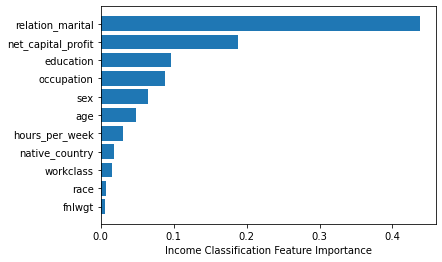

In [595]:
fi = xgbc.feature_importances_
sorted_idx = fi.argsort()
plt.barh(X_train.columns[sorted_idx], xgbc.feature_importances_[sorted_idx])
plt.xlabel("Income Classification Feature Importance")

So, let's analyse these features just a bit, by showing the percentual occurence of a >50k income over relationship status and net capital profit.

We see that married people have an almost 50% occurence of an income over 50k, while for the other groups it is just 10% or even less. So this is a huge predictor.

In [784]:
round(df.groupby('relationship', sort=True)['income'].mean().sort_values(ascending=False)*100,1)

relationship
 Wife              46.9
 Husband           44.9
 Not-in-family     10.1
 Unmarried          6.0
 Other-relative     3.5
 Own-child          1.5
Name: income, dtype: float64

For the net capital profit, interestingly those who either have positive or negative capital profit have a 50% occurence of an income over 50k, while those with exactly 0 profit just have only have a 20% occurence of an 50+k income, which makes sense, because if you have little disposable income to spend on investments, you are less likely to invest and thus will not make or lose money.

In [783]:
round(df.groupby('net_capital_profit', sort=True)['income'].mean().sort_values(ascending=False)*100,1)

net_capital_profit
 1    61.7
-1    50.1
 0    18.9
Name: income, dtype: float64